In [1]:
import common

import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from dotenv import load_dotenv
from datetime import datetime
from zoneinfo import ZoneInfo
import wandb

In [2]:
common.wandb_login_init('efficientnet_b3.ra2_in1k')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kerneld82 (kerneld). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /data/ephemeral/home/.netrc


train_time = efficientnet_b3.ra2_in1k


In [3]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = 'datasets_fin/'

# model config
model_name = 'efficientnet_b3.ra2_in1k' # 'resnet50' 'efficientnet-b0', ...

# training config
trn_img_size = 288
tst_img_size = 320
LR = 1e-3
EPOCHS = 12
BATCH_SIZE = 32
num_workers = 0
augment_ratio = 17

wandb.config.update({
    "learning_rate": LR,
    "architecture": model_name,
    "dataset": "custom-dataset",
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "train_image_size": trn_img_size,
    "test_image_size": tst_img_size,
    'augment_ratio' : augment_ratio,
})

In [4]:
# 시드를 고정합니다.
SEED = 42

common.set_seed(SEED)

In [5]:
device

device(type='cuda')

### Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [6]:
trn_transform = common.create_trn_transform(trn_img_size)
trn_aug_transform = common.create_trn_aug_transform(trn_img_size)
tst_transform = common.create_tst_transform(tst_img_size)

In [7]:
# Dataset 정의
trn_dataset, val_dataset = common.train_dataset_split(
    "datasets_fin/train.csv",
    "datasets_fin/train/",
    trn_transform = trn_transform,
    trn_aug_transform = trn_aug_transform,
    tst_transform = tst_transform,
    augment_ratio = augment_ratio,
    train_size=0.729, 
    random_state=SEED
)

tst_dataset = common.ImageDataset(
    "datasets_fin/sample_submission.csv",
    "datasets_fin/test/",
    transform = tst_transform
)

print("최종", len(trn_dataset), len(val_dataset), len(tst_dataset))

[dataset_split] 훈련 세트: 1635 샘플
[dataset_split] 검증 세트: 609 샘플
최종 27795 609 3140


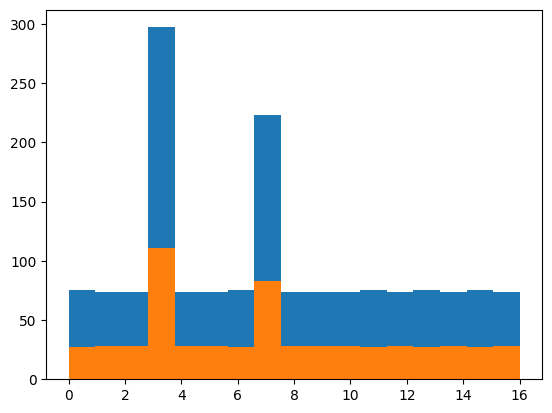

In [8]:
import matplotlib.pyplot as plt
plt.hist(trn_dataset.df[:,1], bins=17)
plt.hist(val_dataset.df[:,1], bins=17)
plt.show()

In [9]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = num_workers,
    pin_memory = True,
    drop_last = False
)

val_loader = DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0,
    pin_memory = True
)

tst_loader = DataLoader(
    tst_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0,
    pin_memory = True
)

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [10]:
len(timm.list_models(pretrained=True))

1298

In [11]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [12]:
common.train_with_start_end_epoch(seed = SEED, 
                                  tst_img_size = tst_img_size,
                                  batch_size = BATCH_SIZE,
                                  start_epoch_inclusive = 0, 
                                  end_epoch_exclusive = EPOCHS, 
                                  augment_ratio = augment_ratio,
                                  trn_loader = trn_loader, 
                                  val_loader = val_loader, 
                                  model = model, 
                                  model_name = model_name, 
                                  optimizer = optimizer, 
                                  loss_fn = loss_fn, 
                                  device = device, 
                                  is_save_model_checkpoint = True, 
                                  is_evaluate_train_valid = True)

Loss: 0.0607: 100%|██████████| 869/869 [12:40<00:00,  1.14it/s]


train_loss: 0.3776
train_acc: 0.8660
train_f1: 0.8966
epoch: 0.0000

Model checkpoint saved. filename: checkpoint-efficientnet_b3.ra2_in1k_seed_42_epoch_0_isFull_False.pt



Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.02it/s]



final_train_loss: 0.10813174053696514
final_train_accuracy: 0.9651376146788991
final_train_f1: 0.97212309163547
final_valid_loss: 0.12134418319910764
final_valid_accuracy: 0.9540229885057471
final_valid_f1: 0.9588342276678304
train's error preds count: 969/27795, {6: 9, 14: 36, 7: 423, 13: 119, 3: 256, 12: 19, 16: 15, 9: 5, 4: 33, 5: 20, 10: 11, 15: 11, 11: 6, 1: 2, 2: 1, 0: 3}
valid's error preds count: 28/609, {10: 3, 13: 2, 7: 13, 3: 1, 14: 3, 16: 1, 4: 5}




Loss: 0.0024: 100%|██████████| 869/869 [12:40<00:00,  1.14it/s]


train_loss: 0.0945
train_acc: 0.9665
train_f1: 0.9771
epoch: 1.0000

Model checkpoint saved. filename: checkpoint-efficientnet_b3.ra2_in1k_seed_42_epoch_1_isFull_False.pt



Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.93it/s]



final_train_loss: 0.030255611908674467
final_train_accuracy: 0.9903220003597769
final_train_f1: 0.9938453812038863
final_valid_loss: 0.07807069170521572
final_valid_accuracy: 0.9704433497536946
final_valid_f1: 0.9756062089972382
train's error preds count: 269/27795, {7: 114, 14: 23, 13: 14, 3: 72, 11: 13, 4: 23, 15: 1, 8: 2, 10: 2, 16: 1, 6: 3, 12: 1}
valid's error preds count: 18/609, {10: 2, 7: 4, 14: 4, 4: 5, 3: 2, 6: 1}




Loss: 0.0017: 100%|██████████| 869/869 [12:40<00:00,  1.14it/s]


train_loss: 0.0701
train_acc: 0.9761
train_f1: 0.9813
epoch: 2.0000

Model checkpoint saved. filename: checkpoint-efficientnet_b3.ra2_in1k_seed_42_epoch_2_isFull_False.pt



Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.89it/s]



final_train_loss: 0.03445476803017143
final_train_accuracy: 0.9883792048929664
final_train_f1: 0.9915189359621968
final_valid_loss: 0.05965884411052684
final_valid_accuracy: 0.9802955665024631
final_valid_f1: 0.9795952270950811
train's error preds count: 323/27795, {3: 164, 7: 89, 13: 2, 4: 44, 14: 9, 11: 4, 12: 2, 9: 1, 2: 3, 5: 2, 10: 1, 6: 1, 8: 1}
valid's error preds count: 12/609, {3: 2, 14: 4, 4: 4, 6: 1, 8: 1}




Loss: 0.1426: 100%|██████████| 869/869 [12:40<00:00,  1.14it/s]


train_loss: 0.0487
train_acc: 0.9837
train_f1: 0.9878
epoch: 3.0000

Model checkpoint saved. filename: checkpoint-efficientnet_b3.ra2_in1k_seed_42_epoch_3_isFull_False.pt



Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.89it/s]



final_train_loss: 0.04902717372424251
final_train_accuracy: 0.984529591653175
final_train_f1: 0.9875974613880686
final_valid_loss: 0.10325982259819284
final_valid_accuracy: 0.9753694581280788
final_valid_f1: 0.9807810819695879
train's error preds count: 430/27795, {7: 24, 11: 55, 3: 183, 13: 65, 15: 5, 14: 32, 10: 15, 12: 2, 6: 2, 4: 39, 1: 1, 9: 3, 8: 2, 2: 2}
valid's error preds count: 15/609, {10: 2, 14: 5, 7: 3, 4: 5}




Loss: 0.0407: 100%|██████████| 869/869 [12:39<00:00,  1.14it/s]


train_loss: 0.0567
train_acc: 0.9814
train_f1: 0.9858
epoch: 4.0000

Model checkpoint saved. filename: checkpoint-efficientnet_b3.ra2_in1k_seed_42_epoch_4_isFull_False.pt



Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.90it/s]



final_train_loss: 0.02964070771988098
final_train_accuracy: 0.9904299334412664
final_train_f1: 0.9932435434148573
final_valid_loss: 0.10616854090185371
final_valid_accuracy: 0.9605911330049262
final_valid_f1: 0.9645903595289566
train's error preds count: 266/27795, {3: 110, 7: 73, 6: 7, 11: 15, 13: 28, 4: 22, 1: 1, 0: 3, 14: 4, 8: 1, 10: 1, 12: 1}
valid's error preds count: 24/609, {3: 2, 10: 2, 7: 7, 14: 4, 4: 8, 12: 1}




Loss: 0.0001: 100%|██████████| 869/869 [12:43<00:00,  1.14it/s]


train_loss: 0.0338
train_acc: 0.9888
train_f1: 0.9911
epoch: 5.0000

Model checkpoint saved. filename: checkpoint-efficientnet_b3.ra2_in1k_seed_42_epoch_5_isFull_False.pt



Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.80it/s]



final_train_loss: 0.035104012896045714
final_train_accuracy: 0.9896024464831804
final_train_f1: 0.9932173561558894
final_valid_loss: 0.16286479183472694
final_valid_accuracy: 0.9589490968801314
final_valid_f1: 0.9718243907818535
train's error preds count: 289/27795, {3: 192, 7: 24, 6: 5, 14: 8, 11: 5, 4: 5, 13: 43, 12: 2, 1: 1, 10: 2, 8: 2}
valid's error preds count: 25/609, {3: 14, 10: 2, 7: 1, 4: 5, 14: 2, 11: 1}




Loss: 0.0355:  29%|██▉       | 252/869 [03:43<09:06,  1.13it/s]


KeyboardInterrupt: 

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [ ]:
common.pred_and_save_to_csv(model, tst_loader, device, "pred.csv")

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:18<00:00,  5.37it/s]


In [ ]:
# wandb 실행 종료
wandb.finish()

final_train_accuracy,▁▁▅▅▆▄▇▇█▆▇█
final_train_f1,▂▁▆▅▆▄▇▇█▆▇█
final_train_loss,██▄▄▃▆▂▂▁▂▂▁
final_valid_accuracy,▁▅▆▇▇▇▇▆█▆▇█
final_valid_f1,▁▄▇▇▇▆▇▅▇▅▆█
final_valid_loss,█▆▄▂▄▁▂▇▄▄▂▂
train_acc,▁▆▇▇▇███████
train_f1,▁▆▇▇▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁
final_train_accuracy,0.99838
final_train_f1,0.99833


In [ ]:
import sys
sys.exit('아래 셀은 수동으로 실행하기 위해서 여기서 실행 멈춤.')

SystemExit: 아래 셀은 수동으로 실행하기 위해서 여기서 실행 멈춤.

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 수동으로 특정 체크포인트부터 이어서 학습하기 위한 부분


In [ ]:
checkpoint = common.load_model_checkpoint("checkpoint-resnet34_seed_42_epoch_0_isFull_False.pt", model, optimizer, device)

In [ ]:
next_epoch = checkpoint['epoch'] + 1

common.train_with_start_end_epoch(seed = checkpoint['seed'],
                           tst_img_size = checkpoint['tst_img_size'],
                           batch_size = checkpoint['batch_size'],
                           start_epoch_inclusive = next_epoch, 
                           end_epoch_exclusive = next_epoch + 2, 
                           augment_ratio = augment_ratio,
                           trn_loader = trn_loader,
                           val_loader = val_loader,
                           model = model,
                           model_name = model_name,
                           optimizer = optimizer,
                           loss_fn = loss_fn,
                           device = device,
                           is_save_model_checkpoint = True,
                           is_evaluate_train_valid = True)

Loss: 1.8031: 100%|██████████| 69/69 [00:09<00:00,  7.38it/s]


train_loss: 2.0972
train_acc: 0.3326
train_f1: 0.3136
epoch: 1.0000

Model checkpoint saved. filename: checkpoint-resnet34_seed_42_epoch_1_isFull_False.pt



Evaluating: 100%|██████████| 15/15 [00:01<00:00,  9.22it/s]



final_train_loss: 1.790640383526899
final_train_accuracy: 0.4349408553230209
final_train_f1: 0.4316298116099343
final_valid_loss: 1.2533869663874309
final_valid_accuracy: 0.5966029723991507
final_valid_f1: 0.5529343340352267




Loss: 1.4048: 100%|██████████| 69/69 [00:09<00:00,  7.48it/s]


train_loss: 1.6951
train_acc: 0.4449
train_f1: 0.4397
epoch: 2.0000

Model checkpoint saved. filename: checkpoint-resnet34_seed_42_epoch_2_isFull_False.pt



Evaluating: 100%|██████████| 15/15 [00:01<00:00,  8.87it/s]


final_train_loss: 1.4995038284771685
final_train_accuracy: 0.5104640582347588
final_train_f1: 0.5326523791669887
final_valid_loss: 1.00657608906428
final_valid_accuracy: 0.6624203821656051
final_valid_f1: 0.6142918510958036
